# ResNet for 48x48 Images - Kaggle

Custom ResNet architecture for 48x48 facial emotion recognition with GPU optimization.

## Setup

Add the FER-2013 dataset before running:
1. Click "Add Data" → Search "fer2013" → Add "msambare/fer2013"
2. Enable GPU: Settings → Accelerator → GPU (P100 or T4)

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten, Input, BatchNormalization, Activation, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, cohen_kappa_score

import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configured: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(f"GPU config error: {e}")

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

TensorFlow version: 2.18.0
GPU Available: Yes
GPU configured: 2 device(s)
Mixed precision enabled


In [28]:
CONFIG = {
    'img_size': (48, 48),
    'batch_size': 256,
    'num_classes': 7,
    'epochs': 100,
    'initial_lr': 0.001,
    'use_grayscale': True,
    'model_type': 'resnet_small'
}

KAGGLE_INPUT = '/kaggle/input/fer2013'
TRAIN_DIR = os.path.join(KAGGLE_INPUT, 'train')
VAL_DIR = os.path.join(KAGGLE_INPUT, 'test')
MODEL_SAVE_PATH = '/kaggle/working/resnet_small_48x48.keras'

print("Configuration:", CONFIG)
print("Train dir:", TRAIN_DIR)
print("Val dir:", VAL_DIR)

if os.path.exists(TRAIN_DIR):
    train_classes = sorted(os.listdir(TRAIN_DIR))
    print("Classes:", train_classes)
    for cls in train_classes:
        cls_path = os.path.join(TRAIN_DIR, cls)
        if os.path.isdir(cls_path):
            print(f"  {cls}: {len(os.listdir(cls_path))} images")

Configuration: {'img_size': (48, 48), 'batch_size': 256, 'num_classes': 7, 'epochs': 100, 'initial_lr': 0.001, 'use_grayscale': True, 'model_type': 'resnet_small'}
Train dir: /kaggle/input/fer2013/train
Val dir: /kaggle/input/fer2013/test
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images


In [29]:
def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1 if CONFIG['use_grayscale'] else 3)
    img = tf.image.resize(img, CONFIG['img_size'])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def augment_image(img, label):
    img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

def create_dataset_from_directory(directory, shuffle=True):
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    
    file_paths = []
    labels = []
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(class_dir, img_name))
                labels.append(class_to_idx[class_name])
    
    labels = tf.keras.utils.to_categorical(labels, num_classes=CONFIG['num_classes'])
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths), seed=42)
    
    return dataset, class_names, len(file_paths)

train_ds, class_names, train_samples = create_dataset_from_directory(TRAIN_DIR, shuffle=True)
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(CONFIG['batch_size'])
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds, _, val_samples = create_dataset_from_directory(VAL_DIR, shuffle=False)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(CONFIG['batch_size'])
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Classes: {class_names}")

all_labels = []
for class_name in class_names:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    all_labels.extend([class_names.index(class_name)] * count)

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, name in enumerate(class_names):
    print(f"  {name}: {class_weights[i]:.3f}")

Training samples: 28709
Validation samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class weights:
  angry: 1.027
  disgust: 9.407
  fear: 1.001
  happy: 0.568
  neutral: 0.826
  sad: 0.849
  surprise: 1.293


In [30]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
    x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = BatchNormalization(name=name + '_2_bn')(x)
    
    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x

def build_small_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input')
    
    x = Conv2D(32, 3, strides=1, padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    
    x = residual_block(x, 32, name='block1_res1')
    x = residual_block(x, 32, name='block1_res2')
    
    x = residual_block(x, 64, stride=2, conv_shortcut=True, name='block2_res1')
    x = residual_block(x, 64, name='block2_res2')
    
    x = residual_block(x, 128, stride=2, conv_shortcut=True, name='block3_res1')
    x = residual_block(x, 128, name='block3_res2')
    
    x = GlobalAveragePooling2D(name='global_pool')(x)
    x = Dropout(0.5, name='dropout')(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='resnet_small')
    return model

input_shape = (*CONFIG['img_size'], 1 if CONFIG['use_grayscale'] else 3)
model = build_small_resnet(input_shape, CONFIG['num_classes'])

optimizer = Adam(learning_rate=CONFIG['initial_lr'])
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Memory: ~{total_params * 4 / 1024 / 1024:.1f} MB")

Model: "resnet_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 48, 48, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_4 (Cast)       │ (None, 48, 48, 1) │          0 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │        320 │ cast_4[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 48, 48,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 48, 48,    │          0 │ bn1[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_1_conv  │ (None, 48, 48,    │      9,248 │ relu1[0][0]       │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_1_bn    │ (None, 48, 48,    │        128 │ block1_res1_1_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_1_relu  │ (None, 48, 48,    │          0 │ block1_res1_1_bn… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_2_conv  │ (None, 48, 48,    │      9,248 │ block1_res1_1_re… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_2_bn    │ (None, 48, 48,    │        128 │ block1_res1_2_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_add     │ (None, 48, 48,    │          0 │ relu1[0][0],      │
│ (Add)               │ 32)               │            │ block1_res1_2_bn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res1_out     │ (None, 48, 48,    │          0 │ block1_res1_add[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res2_1_conv  │ (None, 48, 48,    │      9,248 │ block1_res1_out[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res2_1_bn    │ (None, 48, 48,    │        128 │ block1_res2_1_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res2_1_relu  │ (None, 48, 48,    │          0 │ block1_res2_1_bn… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res2_2_conv  │ (None, 48, 48,    │      9,248 │ block1_res2_1_re… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res2_2_bn    │ (None, 48, 48,    │        128 │ block1_res2_2_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 699,015 (2.67 MB)

 Trainable params: 696,775 (2.66 MB)

 Non-trainable params: 2,240 (8.75 KB)


Total parameters: 699,015
Memory: ~2.7 MB


In [31]:
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

callbacks = [
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


In [32]:
print("Training started")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\nModel saved to: {MODEL_SAVE_PATH}")

Training started
Epochs: 100
Batch size: 256
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.1496 - loss: 2.2141
Epoch 1: val_accuracy improved from -inf to 0.01644, saving model to /kaggle/working/resnet_small_48x48.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.1496 - loss: 2.2128 - val_accuracy: 0.0164 - val_loss: 1.9701 - learning_rate: 0.0010
Epoch 2/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.1639 - loss: 1.9498
Epoch 2: val_accuracy improved from 0.01644 to 0.17637, saving model to /kaggle/working/resnet_small_48x48.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.1639 - loss: 1.9497 - val_accuracy: 0.1764 - val_loss: 1.9245 - learning_rate: 0.0010
Epoch 3/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1630 - loss: 1.9286
Epoch 3: val_accuracy did not improve from 0.17637
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.1631 - loss: 1.9285 - val_accuracy: 0.1704 - val_loss: 1.9823 - lear

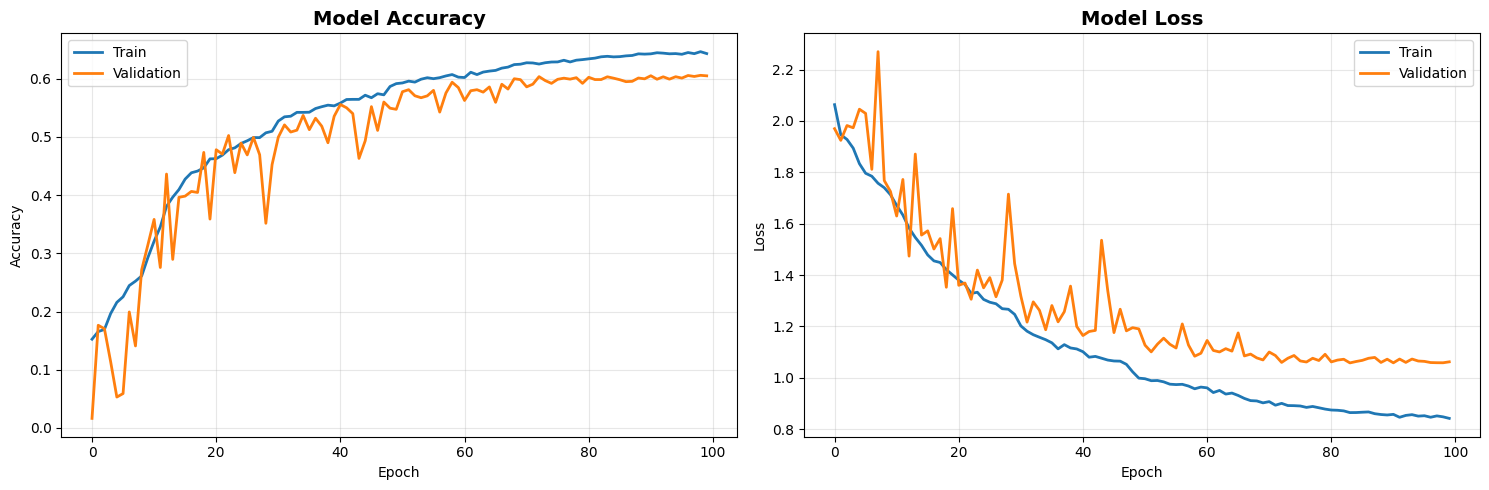

Best epoch: 99
Training accuracy: 0.6462
Validation accuracy: 0.6056


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_train_acc = history.history['accuracy'][best_val_acc_idx]

print(f"Best epoch: {best_val_acc_idx + 1}")
print(f"Training accuracy: {best_train_acc:.4f}")
print(f"Validation accuracy: {best_val_acc:.4f}")

In [34]:
best_model = load_model(MODEL_SAVE_PATH)

print("Evaluating model on validation set...")
val_loss, val_accuracy = best_model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

balanced_acc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Evaluating model on validation set...
Validation Loss: 1.0585
Validation Accuracy: 0.6056

Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.54      0.51       958
     disgust       0.50      0.58      0.54       111
        fear       0.41      0.28      0.33      1024
       happy       0.86      0.82      0.84      1774
     neutral       0.55      0.61      0.58      1233
         sad       0.49      0.49      0.49      1247
    surprise       0.69      0.80      0.74       831

    accuracy                           0.61      7178
   macro avg       0.57      0.59      0.58      7178
weighted avg       0.60      0.61      0.60      7178


Balanced Accuracy: 0.5880
Cohen's Kappa: 0.5245


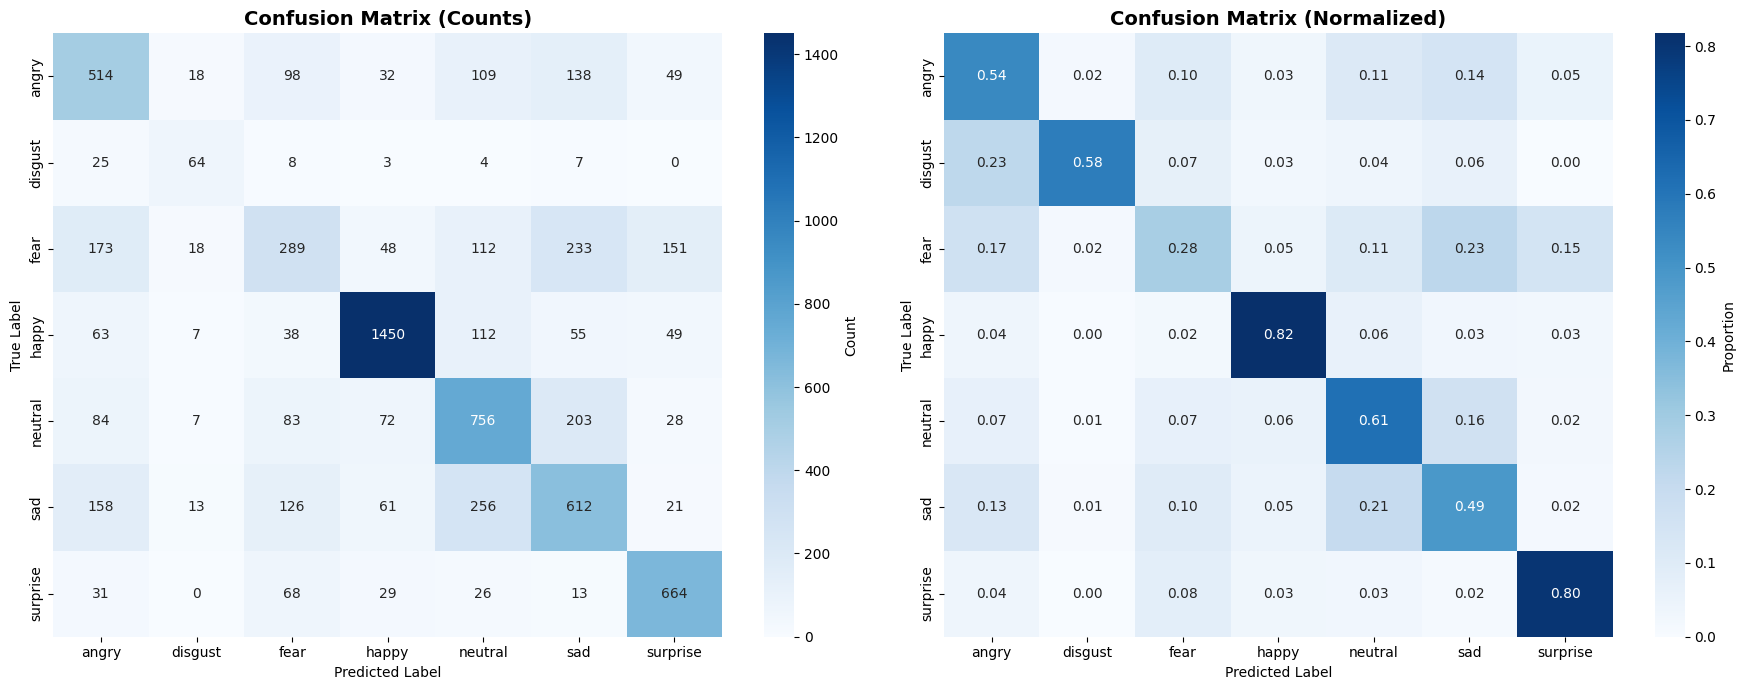

In [35]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


Per-Class Performance:
   Class  Accuracy  Total Samples
   happy  0.817362           1774
surprise  0.799037            831
 neutral  0.613139           1233
 disgust  0.576577            111
   angry  0.536534            958
     sad  0.490778           1247
    fear  0.282227           1024


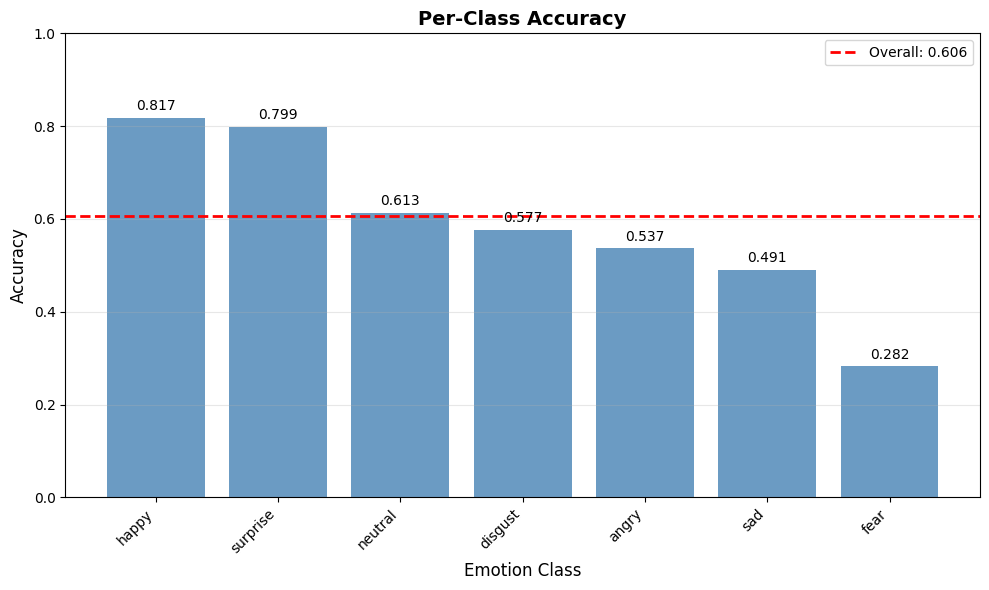

In [36]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

results_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': per_class_accuracy,
    'Total Samples': cm.sum(axis=1)
})

results_df = results_df.sort_values('Accuracy', ascending=False)

print("\nPer-Class Performance:")
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Class'], results_df['Accuracy'], color='steelblue', alpha=0.8)

for i, (bar, acc) in enumerate(zip(bars, results_df['Accuracy'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.axhline(y=val_accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {val_accuracy:.3f}')
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
metrics_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})

metrics_df.to_csv('/kaggle/working/training_metrics.csv', index=False)
results_df.to_csv('/kaggle/working/per_class_results.csv', index=False)

print("Results saved:")
print("  - Model: /kaggle/working/resnet_small_48x48.keras")
print("  - Metrics: /kaggle/working/training_metrics.csv")
print("  - Per-class results: /kaggle/working/per_class_results.csv")

Results saved:
  - Model: /kaggle/working/resnet_small_48x48.keras
  - Metrics: /kaggle/working/training_metrics.csv
  - Per-class results: /kaggle/working/per_class_results.csv
